# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

**Answer: ** Note to the reviewer: Python 2.7 has been used for running this notebook.


## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [3]:
# Import libraries necessary for this project
from __future__ import division
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [4]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data[data.income == '>50K'].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data[data.income == '<=50K'].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

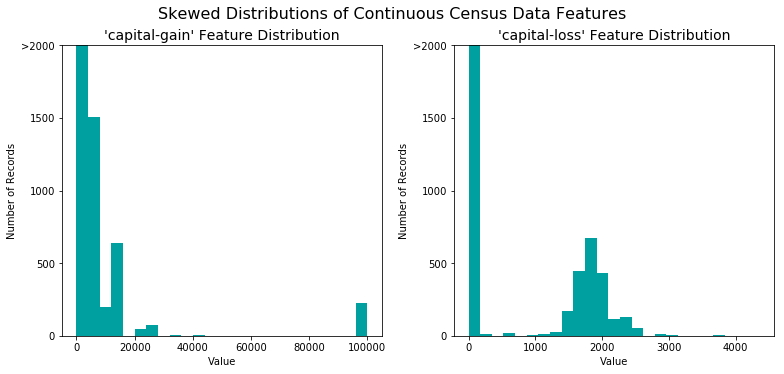

In [5]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

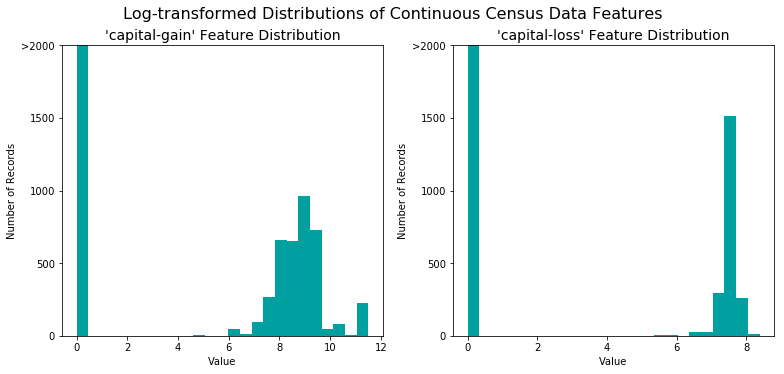

In [6]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [7]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show first record before scaling applied
display(data.head(n = 1))

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [8]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
converter = {'<=50K': 0, '>50K': 1}
income = income_raw.apply(lambda x: converter[x])

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [9]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, stratify = income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


C:\Users\H155936\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [10]:
# TODO: Calculate accuracy
accuracy = n_greater_50k/n_records

# TODO: Calculate F-score using the formula above for beta = 0.5
true_pos = n_greater_50k
false_pos = n_at_most_50k
false_neg = 0
precision = true_pos / (true_pos + false_pos)
recall = true_pos / (true_pos + false_neg)
beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

**Gaussian Naive Bayes**

**Real-world application**: Predicting a person's cognitive activity based on MRI images recorded during the activity [1]. In a study participants were shown different stimulis such as words or pictures. For each stimuli brain activity was measured via MRI. Application of GaussianNB to MRI images allowed to predict the stimuli shown to the participant.

**Strengths:** Naive Bayes models can be trained with a relative small amount of data and perform well with categorical data. [2]

**Weaknesses:** The Naive Bayes (NB) algorithm is based on the assumption of conditional independence between the input variables (this is the reason why it is called "naive"). However, in reality there are often dependencies between variables. These dependencies cannot be modelled using NB [3]. NB works with probabilities which are often small numbers. NB algorithms multiply several probabilities which can lead to even smaller numbers. This can lead to problems with floating point precision. [4]

**Why a good candidate:** GaussianNB seems to be well suited for categorical data. The majority of features in the data set are categorical. The continous features (age, capital-gain, capital-loss and hours-per-week) can be transformed by using probability density functions.

References:

[1] ["Naïve Bayes, Gaussian Distributions, Practical Applications"](http://www.cs.cmu.edu/~tom/10601_sp09/lectures/NBayes2_2-2-2009-ann.pdf)

[2] ["6 Easy Steps to Learn Naive Bayes Algorithm (with code in Python)"](https://www.analyticsvidhya.com/blog/2015/09/naive-bayes-explained/)

[3] ["What are the disadvantages of using a naive bayes for classification?"](https://www.quora.com/What-are-the-disadvantages-of-using-a-naive-bayes-for-classification)

[4] ["Better Naive Bayes: 12 Tips To Get The Most From The Naive Bayes Algorithm"](https://machinelearningmastery.com/better-naive-bayes/)

**Decision Trees**

**Real-world application**: Decision trees have been applied in the field of auditing and the detection of fraudulent financial statements (FFS) [1]. In this study the authors compare the effectiveness of three algorithms (decision trees, neural networks and bayesian belief networks) to detect FFS. The study compiled 27 financial variables of which 10 high informative variables were choosen to form input vectors. Decision tree achived a performance of 73.6% correct classification when applying 10-fold cross validation.

**Strengths:** Decision trees have the capability to handle numerical and categorical data well. A further advantage is their insensitivity to wide variances in the range of values of raw data variables. This means decision trees often can be utilised without data normalisation [2]. Furthermore, the trees generated by decision tree models are relatively easy to explain and can be visualised. This provides a "trace back" capability that allows to understand how a decision/classification has been arrived at. This is also referred to as "white box model" [2]. This contrasts with so called black box models where results are harder to explain (e.g. neural networks).

**Weaknesses:** Decision trees can create overly complex trees that tend to overfit [3]. To contain overfitting additional algorithms are employed to "prune" a tree. The goal with pruning is to reduce the tree without reducing the prediction accuracy measured by a cross validation data set. Finding the optimal decision tree is a nondeterministic polynomial complete (NP-C or NP-complete) problem. NP-complete means that all possible decision trees cannot be calculated in  polynomial time. For this reason decison tree algorithms employ methods (aka heuristics) that do not guarantee a global optimal outcome but allow to calculate solutions within reasonable time. An example would be the greedy algorithm that produces optimal decisions local at node level.

**Why a good candidate:** In the 1994 U.S. Census data set that is being used in this project we find numerical and categorical data types. The ability to handle both data types is an advantage of decision trees. Therefore, decision trees will be a good candidate worth trying.

References:

[1] as outlined in the study ["Data Mining techniques for the detection of fraudulent financial statements" by Kirkos et al. (2007)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.81.8428&rep=rep1&type=pdf).

[2] ["4 key advantages of using decision trees for predictive analytics"](http://www.simafore.com/blog/bid/62333/4-key-advantages-of-using-decision-trees-for-predictive-analytics)

[3] ["Decision Tree 5: overfitting and pruning"](https://www.youtube.com/watch?v=Q4NVG1IHQOU)

**K-Nearest Neighbors**

**Real-world application**: The K-Nearest Neighbors algorithm is often used to detect similar items in a data set. As such it is often used in recommender systems [1].

**Strengths:** There is no computational effort for a learning phase [2]. The effort is spend during the precdiction. This can be a strength in cases where learning efforts need to be minimal.

**Weaknesses:** The computational effort will increase substantially when the dataset gets larger [2].

**Why a good candidate:** K-Nearest Naighbors can help us to identify people who are "similar" to people that earn above $50,000.

References:

[1] ["A Survey of Collaborative Recommendation and the Robustness of Model-Based Algorithms"](ftp://131.107.65.22/pub/debull/A08june/sandvig.pdf)

[2] ["K-nearest neighbours"](http://www.lsi.upc.edu/~bejar/apren/docum/trans/03d-algind-knn-eng.pdf)


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [11]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time 
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start

    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    beta = 0.5
    results['f_train'] = fbeta_score(y_train[:300], predictions_train[:300], beta)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

GaussianNB trained on 362 samples.
GaussianNB trained on 3618 samples.
GaussianNB trained on 36177 samples.
DecisionTreeClassifier trained on 362 samples.
DecisionTreeClassifier trained on 3618 samples.
DecisionTreeClassifier trained on 36177 samples.
KNeighborsClassifier trained on 362 samples.
KNeighborsClassifier trained on 3618 samples.
KNeighborsClassifier trained on 36177 samples.


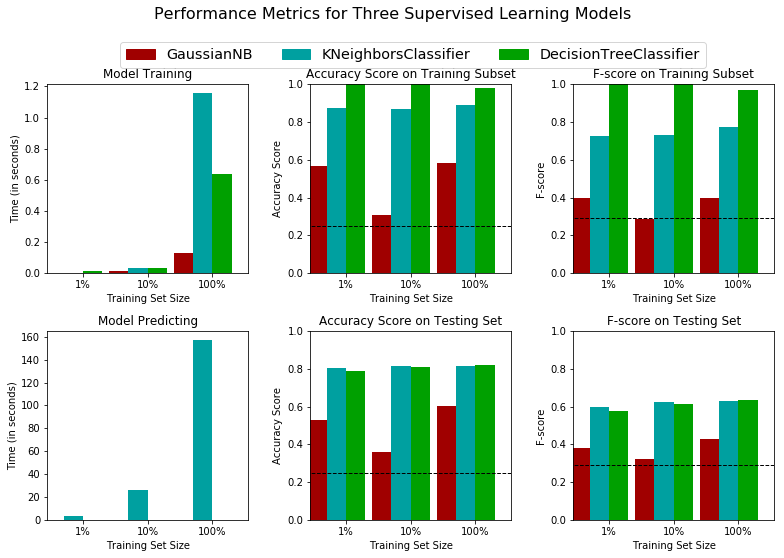

In [12]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier

# TODO: Initialize the three models
random_state = 23
clf_A = GaussianNB()
clf_B = tree.DecisionTreeClassifier(random_state = random_state)
clf_C = KNeighborsClassifier()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(X_train.shape[0] * 0.01))
samples_10 = int(round(X_train.shape[0] * 0.1))
samples_100 = X_train.shape[0]

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **

For the task of identifying individuals that make more than $50,000 I suggest to utilise a decision tree prediction model. In an initial evaluation I looked into the performance of three models: gaussian naive bayes, k-nearest neighbors and decision tree. An initial evaluation shows that k-nearest neighbors and decision tree achieve equivalent accuracy of 0.8 and an F-score of a bit higher than 0.6. However, the k-nearest neighbors model requires significantly more time to make a prediction with test data (160 seconds vs. a few seconds when using the decision tree model). The majority of attributes in the data set are categorical which makes it suitable for a decision tree model. A further advatage is the, already outlined earlier, "trace back" capability of decision tree that allows to understand how a decision/classification has been arrived at.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

When building a decision tree model, features of the data set are used to split the data into subsets (e.g. is sex male?). For each of the features the algorithm performs a spilt. For the resulting subsets it then calculates a score that expresses how well the data has been split. "How well" means how many of the labels in the subset are of the same class. The feature with the best score is then used at the node of the decision tree. The process is repeated for the subsequent lower levels of the decison tree. Typically the algorithm stops growing the tree when there are no more data sets to split or  when all data sets in the subset belong to the same class label. Building the tree is the learning phase of the decision tree algorithm. The tree is then used to make predictions with test or real life data.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [13]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = tree.DecisionTreeClassifier(random_state = random_state)

# TODO: Create the parameters list you wish to tune
parameters = {'max_depth': list(range(1,30)),
              'min_samples_split': list(range(2,50))}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta = 0.5, greater_is_better = True)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(estimator = clf,
                        param_grid = parameters,
                        scoring = scorer,
                        n_jobs = 8)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8197
F-score on testing data: 0.6366

Optimized Model
------
Final accuracy score on the testing data: 0.8549
Final F-score on the testing data: 0.7296


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.2478        |       0.8191      |      0.8549     |
| F-score        |       0.2917        |       0.6366      |      0.7296     |

**Answer: **

The results (accuracy and F-score) for the unoptimised and optimised models are dramatically better than the benchmark predictor results from question 1. Comparing the results from the unoptimised and optimised models alone, a moderate improvement was achieved for the accuracy score (from 0.8191 to 0.8549). Interestingly, a significant improvement was achieved for the F-score (from 0.6366 to 0.7296). With a beta of 0.5 equal importance is given to precision and recall. The improved F-score shows that the model tuning was able to find a more optimal balance between precision and recall.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

1. occupation - intuitively the occupation seems to be the most direct factor determining your income (a "Exec-managerial" will earn more that a "Handlers-cleaners").
2. education-num - the higher the eduction the more likely you earn more
3. education_level - the higher the eduction the more likely you earn more	
4. race
5. sex - if you follow news about professions it appears that race and sex are still reasons for discriminiation in income levels   

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

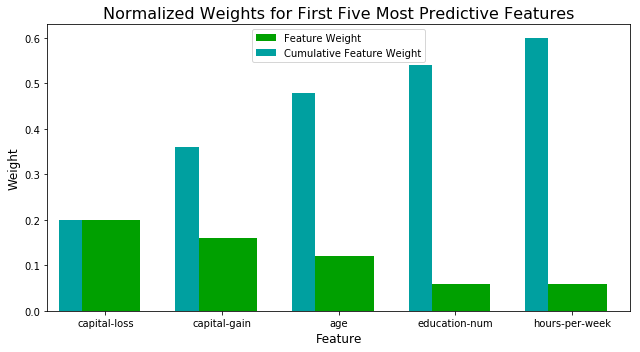

In [14]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set 
model1 = DecisionTreeClassifier()
model1 = model1.fit(X_train, y_train)
model2 = RandomForestClassifier()
model2 = model2.fit(X_train, y_train)
model3 = AdaBoostClassifier()
model3 = model3.fit(X_train, y_train)

# TODO: Extract the feature importances
importances1 = model1.feature_importances_
importances2 = model2.feature_importances_
importances = model3.feature_importances_

# Plot
# vs.feature_plot(importances1, X_train, y_train)
# vs.feature_plot(importances2, X_train, y_train)
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

hmm... only one of the features (eduction-num) I choosed in question 6 is shown in the visualisation.

The features "capital-loss" and "capital-gain" are shown as features with high weight. This probably makes sense. Reporting a capital-loss or gain would mean you had savings with which were investmented in the past. I would expect savings and investments to be more likely with an income >$50,000.

"age" is a strong indicator as people earn more money they gain more experience as they get older.

Higher "hours-per-week" most likely reflects positions with higher skill requirements and responsibilities which usually come with higher income.

What surpises me is that the "occupation" feature doesn't seem to be important. Possibly the available categories did not correctly reflect occupations and some level of random selection was made by the respondent.


### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [21]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train with full feature space
start = time()
clf_full = best_clf.fit(X_train, y_train)
end = time()
print('training time with full feature space: {}'.format(end - start))

# Train on the "best" model found from grid search earlier
start = time()
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
end = time()
print('training time with reduced feature space: {}'.format(end - start))

# Make predictions with full feature space
start = time()
predictions = clf_full.predict(X_test)
end = time()
print('prediction time with full feature space: {}'.format(end - start))

# Make predictions with reduced feature space
start = time()
reduced_predictions = clf.predict(X_test_reduced)
end = time()
print('prediction time with reduced feature space: {}'.format(end - start))

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

training time with full feature space: 0.286000013351
training time with reduced feature space: 0.0310001373291
prediction time with full feature space: 0.0149998664856
prediction time with reduced feature space: 0.0
Final Model trained on full data
------
Accuracy on testing data: 0.8549
F-score on testing data: 0.7296

Final Model trained on reduced data
------
Accuracy on testing data: 0.8315
F-score on testing data: 0.6784


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

Accuracy dropped by about 2.2% (from 0.8549 to 0.8315) and F-score by about 5.6% (from 0.7296 to 0.6784). For the actual use case of predicting who earns above $50,000 the total runtime of training and predicting is only a few seconds. In this case I  prefer to run with the full data and gain higher accuracy and F-score.

I measured the time spent for training and predicting and it became visible that reducing the number of features allows to gain significant performance. Training time dropped by a factor 10 from 0.3s to 0.03s and prediction significantly from 0.014s to close to zero seconds. For use cases with very long training and prediction times these performance gains make it well worth to consider a slightly lower accuracy and F-score.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.